<a href="https://www.kaggle.com/code/clemwo/competition-nlp-with-disaster-tweets?scriptVersionId=202651754" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
%pip install langdetect
%pip install seaborn --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 21.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=c89f099ea589a9e36f1c742a0d1ee6fb367d1b3ea424d149610d4390520ab42e
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.9.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.0 which is incompatible

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
sns.set_context('notebook', font_scale=1.2)

import warnings
warnings.filterwarnings("ignore")

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


<h1 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 46px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(0, 138, 216, 0.6); padding: 25px; border-radius: 10px;">
    🔥Competition 🏆 NLP with Disaster Tweets🦜
</h1>

> This notebooks builds models for [Kaggles Desaster Tweets 🦜 competition](https://www.kaggle.com/competitions/nlp-getting-started). The objective is to develop a model to predict which Tweets are about real disasters and which ones are not. The submission evaluation metric is the [F1-Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) between the predicted and expected answers. The format of the submission file submission.csv should be as follows:
```
    id,target
    0,0
    2,0
    3,1
    9,0
    11,0
```
> where `1` stands for a tweet describing a real disaster, and `0` otherwise.

In [3]:
tweets = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
print(f"Rows: {tweets.shape[0]:,}")
print(f"Cols: {tweets.shape[1]:,}")
tweets.head(5)

Rows: 7,613
Cols: 5


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Seems that `text` is the most useful column to use to predict the `target`. However, the columns are described as follows: 

| Column | Description |
|:-------|:------------|
| `keyword` | A keyword from that tweet (this may be blank). | 
| `location` | The location the tweet was sent from (this may be blank). | 
| `text` | The text of the tweet. | 
| `target` | $1$ if the tweet is about a real desaster, $0$ otherwise. |

In [4]:
TWITTER_BLUE = '#008AD8'

<h1 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(0, 138, 216, 0.3); padding: 20px; border-radius: 10px;">
    Overview of the Data
</h1>

In [5]:
stats = pd.DataFrame({
    'Variable Name': tweets.columns,
    'Missing Count': tweets.isnull().sum().values,
    'Missing Rate (%)': 100*tweets.isnull().mean().values,
    'Unique Count': tweets.nunique().values,
    'Unique Rate (%)': 100*tweets.nunique().values / len(tweets)
}).sort_values(['Missing Rate (%)'], ascending=False)
stats

,Variable Name,Missing Count,Missing Rate (%),Unique Count,Unique Rate (%)
2,location,2533,33.272035,3341,43.885459
1,keyword,61,0.801261,221,2.902929
0,id,0,0.000000,7613,100.000000
3,text,0,0.000000,7503,98.555103
4,target,0,0.000000,2,0.026271


- 33% of all the tweets don't have information about their location.
- Only 0.8% of all the tweest don't have information about a keyword from that tweet.
- there are only 221 (2.9%) unique keywords in all the training set.
- There are no empy tweets 😄 Meaning, every tweet has some text.

Frist, we want to visualize the distribution of the target variable in terms of disaster tweets (`1`) and non-disaster tweets (`0`) to check for class imbalance.

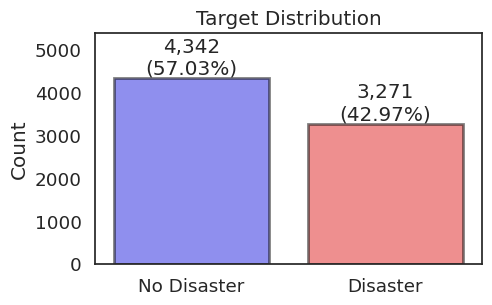

In [6]:
plt.figure(figsize=(5, 3))

ax = sns.countplot(x='target', data=tweets, 
                   linewidth=2.0, edgecolor='black', 
                   palette=['blue', 'red'], alpha=0.5)
ax.set_xticklabels(['No Disaster', 'Disaster'])
ax.set_xlabel('')
ax.set_ylabel('Count')
ax.set_ylim((0, 5_400))
plt.title('Target Distribution')

total = len(tweets)
for p in ax.patches:
    count = p.get_height()
    percentage = f'{100 * count / total:.2f}%'
    ax.text(p.get_x() + p.get_width() / 2, count + 0.5, f'{count:,.0f}\n({percentage})', ha='center', va='bottom')

plt.show()

Let's try to understand the variation of lengths of the tweets in the dataset. 

In [7]:
tweets['text_length'] = tweets['text'].apply(len)
tweets['word_count'] = tweets['text'].apply(lambda x: len(x.split(' ')))

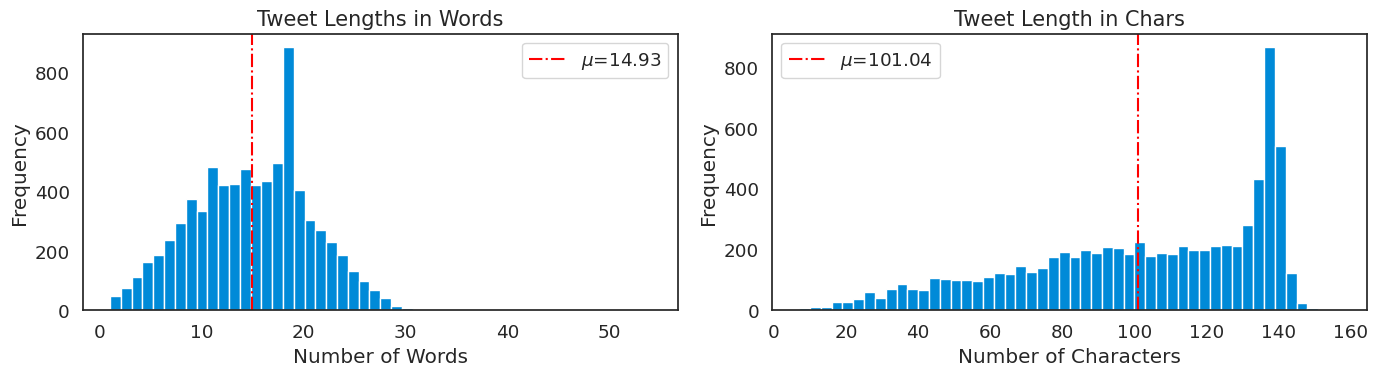

In [8]:
avg_length_words = np.mean(tweets['word_count'])
avg_length_chars = np.mean(tweets['text_length'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# --- Length of tweets in words ---
ax1.hist(tweets['word_count'], bins=50, color=TWITTER_BLUE, edgecolor='white')
ax1.axvline(avg_length_words, color='red', linestyle='-.', label=f'$\mu$={avg_length_words:.2f}')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.set_title('Tweet Lengths in Words', fontsize=15)

# --- Length of tweets in characters ---
ax2.hist(tweets['text_length'], bins=50, color=TWITTER_BLUE, edgecolor='white')
ax2.axvline(avg_length_chars, color='red', linestyle='-.', label=f'$\mu$={avg_length_chars:.2f}')
ax2.set_xlabel('Number of Characters')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.set_title('Tweet Length in Chars', fontsize=15)

plt.tight_layout()
plt.show()

Now we compare text lengths between disaster and non-disaster tweets.

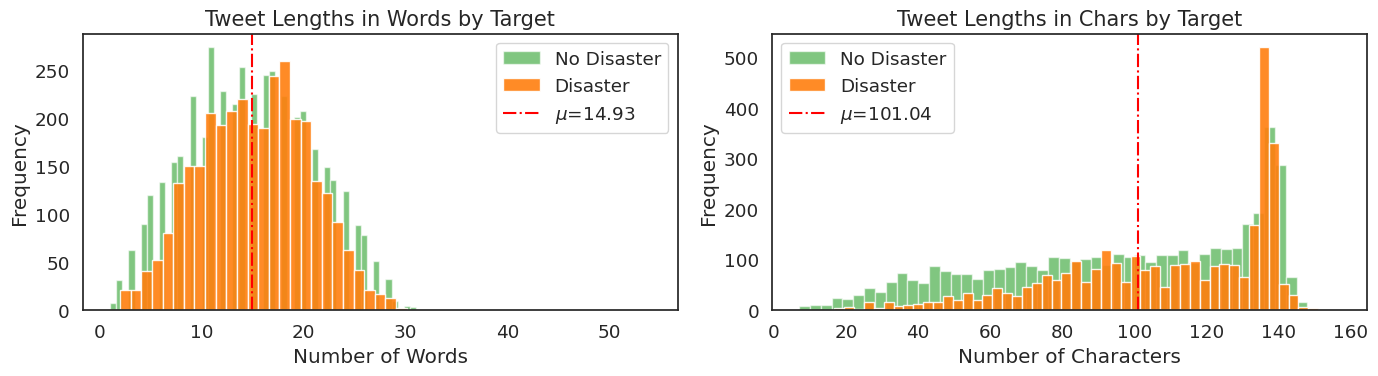

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# --- Length of tweets in words split by target ---
ax1.hist(tweets[tweets['target'] == 0]['word_count'], bins=50, color='C2', edgecolor='white', alpha=0.6, label='No Disaster')
ax1.hist(tweets[tweets['target'] == 1]['word_count'], bins=50, color='C1', edgecolor='white', alpha=0.9, label='Disaster')
ax1.axvline(avg_length_words, color='red', linestyle='-.', label=f'$\mu$={avg_length_words:.2f}')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.set_title('Tweet Lengths in Words by Target', fontsize=15)

# --- Length of tweets in characters split by target ---
ax2.hist(tweets[tweets['target'] == 0]['text_length'], bins=50, color='C2', edgecolor='white', alpha=0.6, label='No Disaster')
ax2.hist(tweets[tweets['target'] == 1]['text_length'], bins=50, color='C1', edgecolor='white', alpha=0.9, label='Disaster')
ax2.axvline(avg_length_chars, color='red', linestyle='-.', label=f'$\mu$={avg_length_chars:.2f}')
ax2.set_xlabel('Number of Characters')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.set_title('Tweet Lengths in Chars by Target', fontsize=15)

plt.tight_layout()
plt.show()

Let's also take a look at the same visualization but using a boxplot instead. 

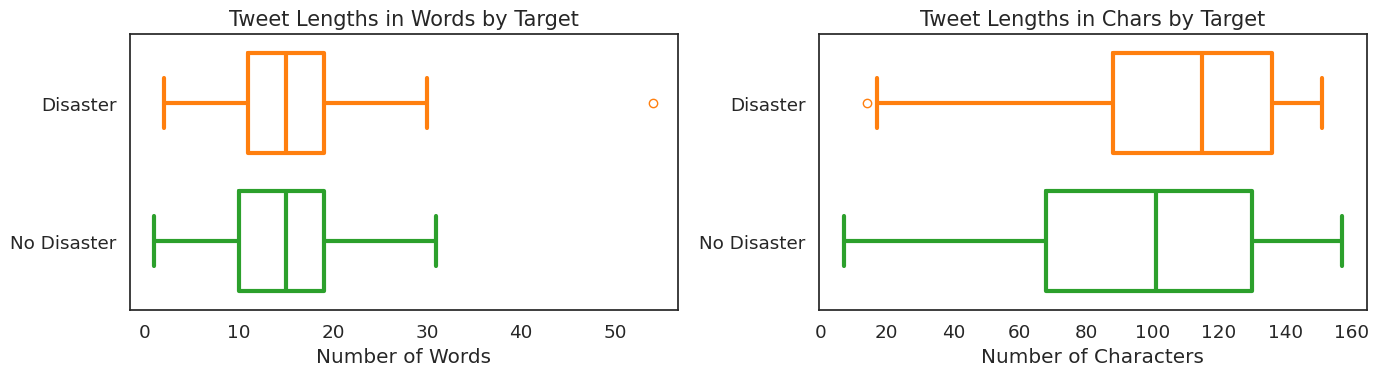

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# --- Length of tweets in words ---
sns.boxplot(data=tweets, x='word_count', hue='target', orient='h', fill=False,
            y=['No Disaster' if t == 0 else 'Disaster' for t in tweets['target']], 
            linewidth=3.0, legend=False, ax=ax1, gap=0.1, palette=['C2', 'C1'])
ax1.set_xlabel('Number of Words')
ax1.set_title('Tweet Lengths in Words by Target', fontsize=15)

# --- Length of tweets in characters ---
sns.boxplot(data=tweets, x='text_length', hue='target', orient='h', fill=False,
            y=['No Disaster' if t == 0 else 'Disaster' for t in tweets['target']], 
            linewidth=3.0, legend=False, ax=ax2, gap=0.1, palette=['C2', 'C1'])
ax2.set_xlabel('Number of Characters')
ax2.set_title('Tweet Lengths in Chars by Target', fontsize=15)

plt.tight_layout()
plt.show()

Now, we will check the correlation between the `word_count` and the `text_length`.

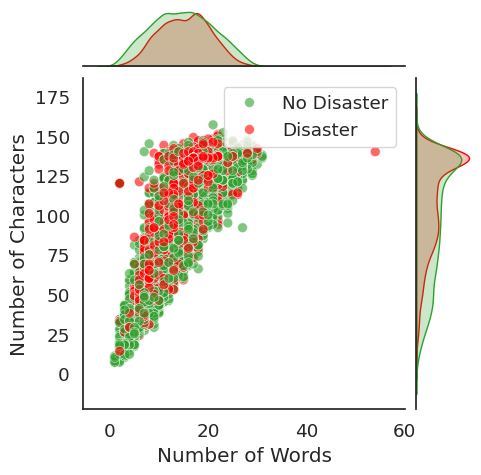

In [11]:
palette = {0: 'C2', 1: 'red'}

g = sns.jointplot(
    data=tweets, 
    x="word_count", 
    y="text_length", 
    hue="target", 
    height=5, 
    palette=palette, 
    joint_kws={'s': 50, 'alpha': 0.6}
)
plt.xlabel('Number of Words')
plt.ylabel('Number of Characters')

handles, labels = g.ax_joint.get_legend_handles_labels()
g.ax_joint.legend(handles, ['No Disaster', 'Disaster'], loc='upper right')

plt.show()

<h1 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(0, 138, 216, 0.3); padding: 20px; border-radius: 10px;">
    Top Words and N-grams
</h1>

In this section we are going to perform Tokenization and Frequency Analysis.
- __Tokenization__: Tokenize the text and remove stopwords.
- __Frequency Analysis__: Identify the most frequent words, bigrams, and trigrams in each class.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

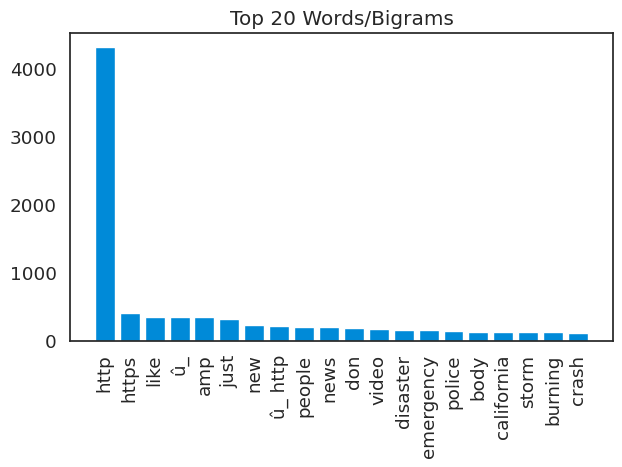

In [13]:
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2))
X = vectorizer.fit_transform(tweets['text'])

sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

top_20 = words_freq[:20]
words, counts = zip(*top_20)

plt.figure(figsize=(7, 4))

plt.bar(words, counts, color=TWITTER_BLUE)
plt.xticks(rotation=90)
plt.title('Top 20 Words/Bigrams')

plt.show()

<h1 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(0, 138, 216, 0.3); padding: 20px; border-radius: 10px;">
    Word Clouds
</h1>

Now we create word clouds for disaster and non-disaster tweets to visualize prominent terms.


In [14]:
from wordcloud import WordCloud

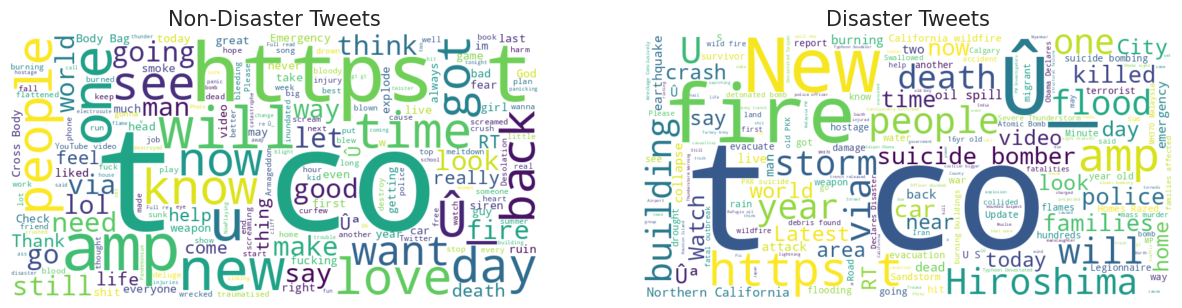

In [15]:
disaster_text = ' '.join(tweets[tweets['target'] == 1]['text'])
non_disaster_text = ' '.join(tweets[tweets['target'] == 0]['text'])

wordcloud_disaster = WordCloud(width=800, height=400, background_color='white').generate(disaster_text)
wordcloud_non_disaster = WordCloud(width=800, height=400, background_color='white').generate(non_disaster_text)

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(wordcloud_non_disaster, interpolation='bilinear')
plt.title('Non-Disaster Tweets', fontsize=15)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(wordcloud_disaster, interpolation='bilinear')
plt.title('Disaster Tweets', fontsize=15)
plt.axis('off')

plt.show()


We clearly see a discrepancy in the words used in disaster tweets compared to words used in non-disaster tweets. For example, `suicide bomber` seems to be a word occuring often in disaster tweets while it's not occuring in non-disaster tweets. However, the most common words are `t` and `co` in both, disaster and non-disaster tweets. 

__Words Highly Occuring Only in Disaster Tweets__ (following shows a subset): 
```
    fire
    suicide bomber
    hiroshima
    building
    storm
    earthquake
    death
```

__Words Highly Occuring Only in Non-Disaster Tweets__ (following shows a subset): 
```
    people
    good
    day
    going 
    love
    help
    new
```

<h1 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(0, 138, 216, 0.3); padding: 20px; border-radius: 10px;">
    Hashtags
</h1>

Here we extract hashtags from the text and analyze their frequency.

In [16]:
import re
from collections import Counter

In [17]:
def plot_hashtag_distribution(_tweets, ax, title, colormap):
    _tweets['hashtags'] = _tweets['text'].apply(lambda x: re.findall(r'#\w+', x.lower()))
    all_hashtags = [hashtag for hashtags in _tweets['hashtags'] for hashtag in hashtags]
    hashtag_counts = Counter(all_hashtags)

    top_hashtags = hashtag_counts.most_common(20)
    hashtags, counts = zip(*top_hashtags)

    sns.barplot(x=list(counts), y=list(hashtags), hue=list(hashtags), 
                palette=colormap, dodge=False, legend=False, ax=ax)
    ax.set_title(title)

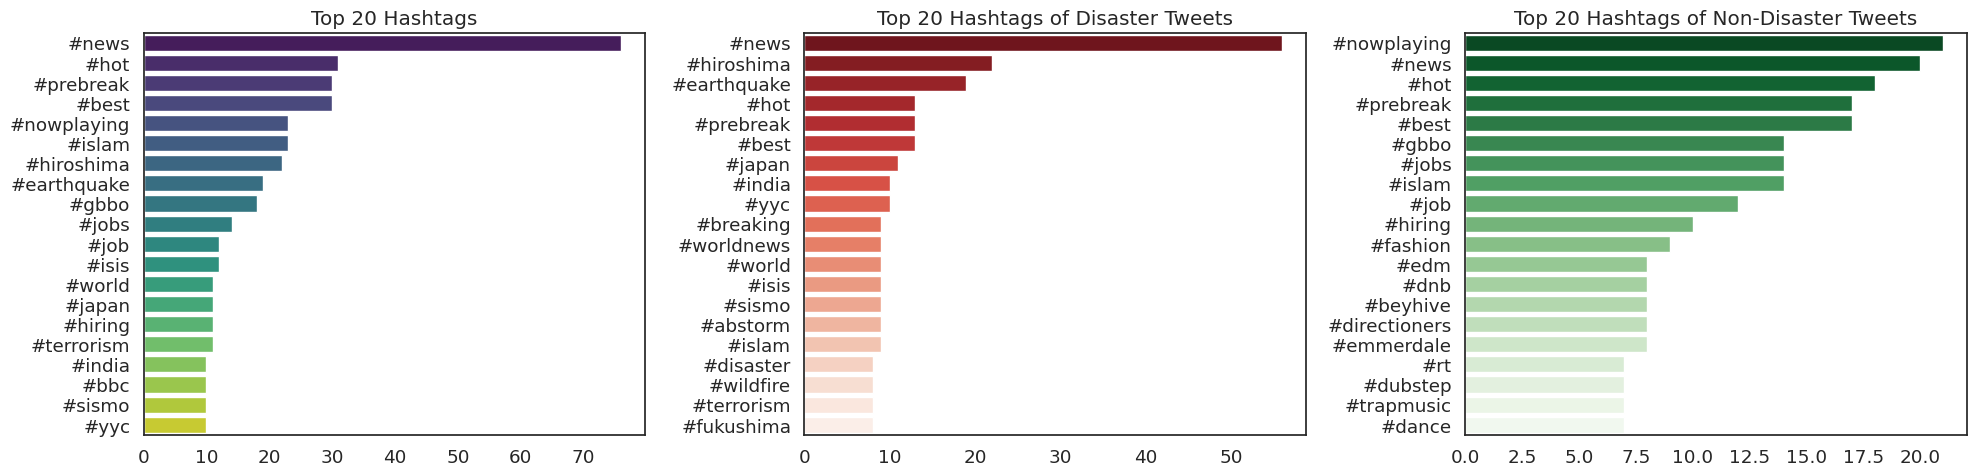

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

plot_hashtag_distribution(tweets, axes[0], 'Top 20 Hashtags', 'viridis')
plot_hashtag_distribution(tweets[tweets['target'] == 1], axes[1], 'Top 20 Hashtags of Disaster Tweets', 'Reds_r')
plot_hashtag_distribution(tweets[tweets['target'] == 0], axes[2], 'Top 20 Hashtags of Non-Disaster Tweets', 'Greens_r')

plt.tight_layout()

plt.show()

<h1 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(0, 138, 216, 0.3); padding: 20px; border-radius: 10px;">
    Named Entity Recognition (NER)
</h1>

In this section we want to identify locations and organizations. We aim to extract entities like locations, organizations, and persons.

In [19]:
import spacy

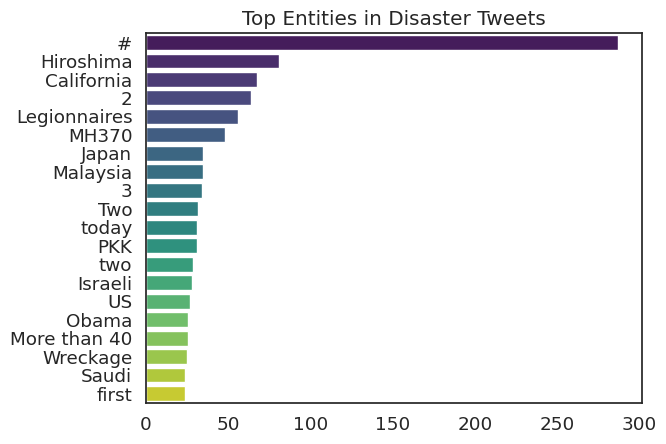

In [20]:
nlp = spacy.load('en_core_web_sm')

def extract_entities(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents]

tweets['entities'] = tweets['text'].apply(extract_entities)

disaster_entities = [ent for ents in tweets[tweets['target'] == 1]['entities'] for ent in ents]
disaster_entity_counts = Counter(disaster_entities).most_common(20)

entities, counts = zip(*disaster_entity_counts)
sns.barplot(x=list(counts), y=list(entities), hue=list(entities), 
            palette='viridis', dodge=False, legend=False)
plt.title('Top Entities in Disaster Tweets')
plt.show()

<h1 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(0, 138, 216, 0.3); padding: 20px; border-radius: 10px;">
    Sentiment Analysis
</h1>

In [21]:
from textblob import TextBlob

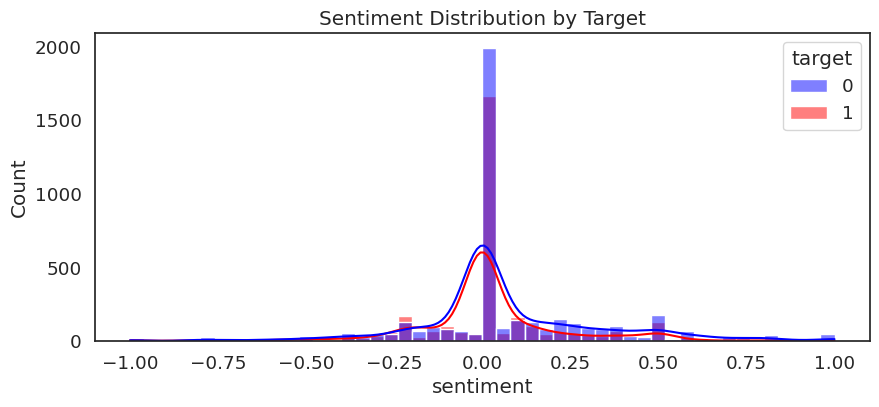

In [22]:
tweets['sentiment'] = tweets['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(10, 4))

sns.histplot(data=tweets, x='sentiment', bins=50, kde=True, hue='target', palette=['blue', 'red'])
plt.title('Sentiment Distribution by Target')

plt.show()

<h1 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(0, 138, 216, 0.3); padding: 20px; border-radius: 10px;">
    Language Detection
</h1>

Before we apply further methods, let's detect the language (just for the fun of it).

In [23]:
from langdetect import detect

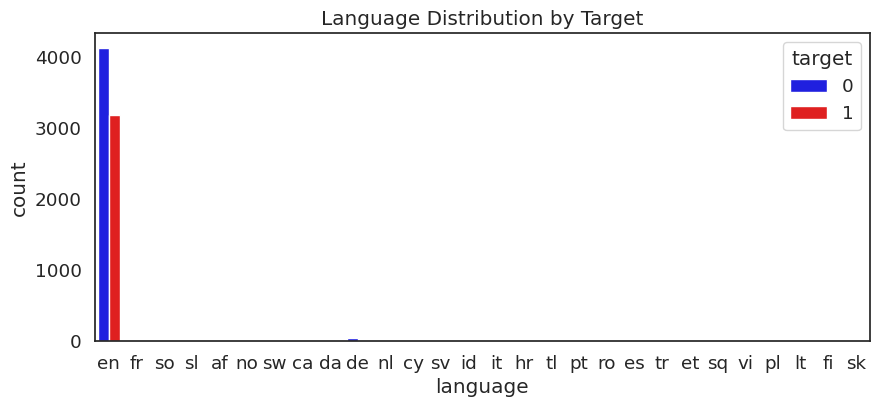

In [24]:
plt.figure(figsize=(10, 4))

tweets['language'] = tweets['text'].apply(lambda x: detect(x) if isinstance(x, str) else 'unknown')
sns.countplot(x='language', hue='target', data=tweets, palette=['blue', 'red'])
plt.title('Language Distribution by Target')

plt.show()

It's english 🇺🇸, who would have thought that 🤭 Jokes aside, actually there are also some other language present. Only in small occurences though.

<h1 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(0, 138, 216, 0.3); padding: 20px; border-radius: 10px;">
    TF-IDF Analysis
</h1>

Now we want to identify important terms using [TF-IDF](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [26]:
tfidf = TfidfVectorizer(stop_words='english', max_features=20)
tfidf_matrix = tfidf.fit_transform(tweets['text'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df.describe()

,amp,body,burning,california,crash,disaster,don,emergency,http,https,just,like,new,news,people,police,storm,suicide,video,û_
count,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000
mean,0.033593,0.014463,0.013310,0.013157,0.012645,0.016188,0.021662,0.017099,0.357003,0.045747,0.035716,0.037536,0.022965,0.019989,0.021835,0.014483,0.013459,0.013113,0.016955,0.034112
std,0.168653,0.111561,0.107924,0.105836,0.105745,0.120753,0.139408,0.120906,0.434663,0.197194,0.175728,0.180029,0.135807,0.127628,0.136828,0.112153,0.108690,0.107581,0.119538,0.160718
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<h1 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(0, 138, 216, 0.3); padding: 20px; border-radius: 10px;">
    Topic Modeling (LDA)
</h1>

Now let's try to discover unrelated topics in tweets by applying [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) (LDA).

In [27]:
from sklearn.decomposition import LatentDirichletAllocation

In [28]:
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}:")
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

Topic 0:
['amp', 'video', 'body', 'people', 'û_', 'crash', 'emergency', 'new', 'like', 'http']
Topic 1:
['people', 'don', 'https', 'news', 'emergency', 'new', 'like', 'http', 'amp', 'just']
Topic 2:
['new', 'crash', 'emergency', 'like', 'http', 'burning', 'police', 'disaster', 'video', 'don']
Topic 3:
['û_', 'emergency', 'crash', 'new', 'like', 'http', 'california', 'news', 'people', 'https']
Topic 4:
['https', 'crash', 'like', 'emergency', 'new', 'suicide', 'storm', 'body', 'http', 'û_']


<h1 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(0, 138, 216, 0.3); padding: 20px; border-radius: 10px;">
    Correlations
</h1>

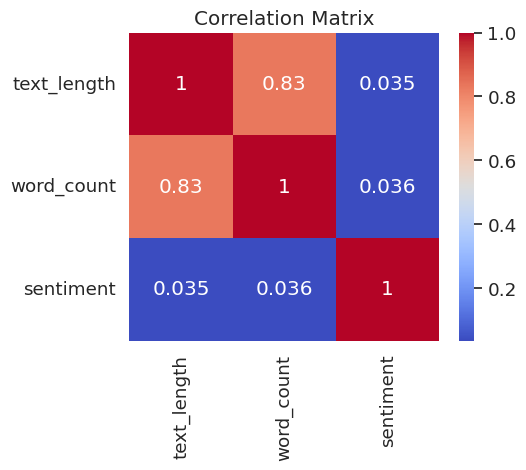

In [29]:
numerical_features = ['text_length', 'word_count', 'sentiment']

plt.figure(figsize=(5, 4))

sns.heatmap(tweets[numerical_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

plt.show()

---

Now let's start to build a model which predicts the `target` which states whether it is a disaster tweet or not. 

<h1 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(0, 138, 216, 0.3); padding: 20px; border-radius: 10px;">
    Text Processing
</h1>

In [30]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('wordnet')  # To resolve the error
nltk.download('omw-1.4')  # Optional but recommended
nltk.download('stopwords')  # If you're using stopwords
nltk.download('punkt')  # If you're using tokenizers

!unzip -o /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

# Initialize Lemmatizer and Stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corp

In [31]:
def remove_noise(text):
    return re.sub(r'http\S+|www\S+|@\S+|#\S+|[^a-zA-Z\s]', '', text)

def tokenize_and_lemmatize(text):
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

def preprocess_text(text):
    text = remove_noise(text)
    text = text.lower()
    text = tokenize_and_lemmatize(text)
    
    return text

We preprocess the data by removing and noise as well as tokenize and lemmatize the text.

In [32]:
tweets['text_cleaned'] = tweets['text'].apply(preprocess_text)
tweets[['text', 'text_cleaned']].head(10)

,text,text_cleaned
0,Our Deeds are the Reason of this #earthquake M...,deed reason may allah forgive u
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,resident asked shelter place notified officer ...
3,"13,000 people receive #wildfires evacuation or...",people receive evacuation order california
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby smoke pours school
5,#RockyFire Update => California Hwy. 20 closed...,update california hwy closed direction due lak...
6,#flood #disaster Heavy rain causes flash flood...,heavy rain cause flash flooding street manitou...
7,I'm on top of the hill and I can see a fire in...,im top hill see fire wood
8,There's an emergency evacuation happening now ...,there emergency evacuation happening building ...
9,I'm afraid that the tornado is coming to our a...,im afraid tornado coming area


In [33]:
# Handle missing values in 'keyword' and 'location' columns
tweets['keyword'].fillna('none', inplace=True)
tweets['location'].fillna('unknown', inplace=True)

tweets[['keyword', 'location', 'text_cleaned', 'target']].head(10)

,keyword,location,text_cleaned,target
0,none,unknown,deed reason may allah forgive u,1
1,none,unknown,forest fire near la ronge sask canada,1
2,none,unknown,resident asked shelter place notified officer ...,1
3,none,unknown,people receive evacuation order california,1
4,none,unknown,got sent photo ruby smoke pours school,1
5,none,unknown,update california hwy closed direction due lak...,1
6,none,unknown,heavy rain cause flash flooding street manitou...,1
7,none,unknown,im top hill see fire wood,1
8,none,unknown,there emergency evacuation happening building ...,1
9,none,unknown,im afraid tornado coming area,1


<h1 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(0, 138, 216, 0.3); padding: 20px; border-radius: 10px;">
    Feature Engineering
</h1>

In [34]:
# Feature Engineering - Extract features from 'keyword' and 'location' columns

# Extract keyword length as a feature
tweets['keyword_length'] = tweets['keyword'].apply(lambda x: len(x) if x != 'none' else 0)

# Extract location presence (binary feature indicating whether location is provided or not)
tweets['has_location'] = tweets['location'].apply(lambda x: 0 if x == 'unknown' else 1)

# Feature: Length of the cleaned text
tweets['text_length'] = tweets['text_cleaned'].apply(lambda x: len(x.split()))

# Feature: Number of unique words in the text
tweets['unique_word_count'] = tweets['text_cleaned'].apply(lambda x: len(set(x.split())))

tweets[['keyword_length', 'has_location', 'text_length', 'unique_word_count', 'target']].head(10)

,keyword_length,has_location,text_length,unique_word_count,target
0,0,0,6,6,1
1,0,0,7,7,1
2,0,0,11,9,1
3,0,0,5,5,1
4,0,0,7,7,1
5,0,0,9,9,1
6,0,0,10,10,1
7,0,0,6,6,1
8,0,0,7,7,1
9,0,0,5,5,1


<h1 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(0, 138, 216, 0.3); padding: 20px; border-radius: 10px;">
    Modeling
</h1>

<h2 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 28px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(0, 138, 216, 0.2); padding: 20px; border-radius: 10px;">
    Logistic Regression
</h2>

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, classification_report

# --- Preparation ---
X = tweets[['keyword_length', 'has_location', 'text_length', 'unique_word_count']]
y = tweets['target']

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Training ---
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [36]:
# --- Predict ---
y_pred = model.predict(X_test)

# --- Validation ---
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(f'Recall  : {recall:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.59
Recall  : 0.21
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.86      0.71       874
           1       0.54      0.21      0.31       649

    accuracy                           0.59      1523
   macro avg       0.57      0.54      0.51      1523
weighted avg       0.57      0.59      0.54      1523



---

💚 Thank you for reading 💚

If you have any questions or feedback, feel free to leave a comment 🤔

This notebook is __still in progress__.

Please __UPVOTE__ if you enjoyed this notebook 🙏